# Datathon: COVID-19 USA
## Importación de la base de datos.

Para importar la base de datos, se va a utilizar la biblioteca requests para solicitar los datos directamente a la página. De esta forma estandarizamos la adiquisición de los datos para que todos los usuarios puedan obtener los mismos resultados. 

Otra opción es descargar los datos directamente en formato JSON o CSV desde la página web del proyecto, y posteriormente importarlos en python empleando los métodos apropiados.

In [ ]:
import pandas as pd
import requests

url = "https://api.covidtracking.com/v1/states/daily.json"

response = requests.get(url)

if response.status_code == 200:
    states_data = response.json()

    df = pd.DataFrame(states_data)

else:
    print(f"Error al solicitar los datos. Código {response.status_code}")


# Si queremos usar el archivo descargado utilizar pd.read_json o pd.read_csv en función del archivo descargado.


## Limpieza de la base de datos.

Una vez se han importado los datos, se debe decidir la forma en la que se va a comenzar la aproximación a la base. Dependiendo del trabajo de investigación que estemos realizando, o de lo que se nos haya solicitado en un entorno laboral, existen dos posibilidades:

- Trabajar con la totalidad de la base de datos y "pescar" resultados.
- Elegir una serie de variables de interés y extraer conclusiones.

Un detalle importante, que por el tipo de trabajo ante el que nos encontramos no estamos teniendo en cuenta, es que toda investigación tiene que ir apoyada sobre una base teórica. Cualquier investigación requiere que tengamos unos conceptos previos que lleven de la mano la investigación. Por ejemplo, en este proyecto de casos de COVID en EEUU, podríamos plantear una posible investigación que explore la hipótesis de que los estados con mayor número de vacunados son los estados que más ven reducida la mortalidad por COVID. Pero para hacer este proceso, necesitaríamos haber realizado previamente una revisión teórica que avale el sentido de esta hipótesis. La extensión de la misma depende mucho del entorno en el que nos estemos desarrollando, y en el caso de entornos laborales empresariales no encontraremos esta limitación a menudo, pero es tarea nuestra como expertos el aportar los buenos haceres en el trabajo.

Si bien es cierto que hoy en día con la expansión y mejora de los modelos de redes neuronales, machine learning, e IA en muchas ocasiones se plantean investigaciones en las que simplemente se buscan resultados "a peso". Es decir, se introducen todas las variables de las que disponemos y esperamos que se nos devuelva el mejor modelo posible. Hacer esto por supuesto es muy inoperante a nivel científico, ya que no disponer de una buena base teórica puede llevarnos a aceptar resultados totalmente incongruentes con la realidad, y a no tener en cuenta factores externos (variables de confusión, correlaciones espúreas, etc.) o posibles sesgos en la elaboración del modelo (¿son nuestros datos de calidad?). 

Otro punto importante a destacar es que, en investigación científica, trabajar con bases de datos preexistentes no siempre es lo más recomendado, ya que es una parte del proceso de investigación sobre el que perdemos el control, y no podemos determinar si se han llevado a cabo los controles suficientes y necesarios sobre la recogida de datos. Además, hay que tener en cuenta que no todo tipo de dato admite todo tipo de prueba estadística. Cuando se trabaja con modelos de machine learning nos encontraremos con casos en los que no se presta mucha atención a estas limitaciones, pero es importante considerar que tipo de dato disponemos en función de su recogida (transversal o longitudinal), en función de su tipología (binario, multinomial, continuo...) y en función del cumplimiento de supuestos en las variables relevantes.

Hecho este preámbulo, las consideraciones para limpiar la base de datos en este caso serán:
- Variables de interés (columnas que queremos quedarnos)
- Adecuación del formato (revisar que los datos sean congruentes con la variable)
- Análisis de datos perdidos (revisar el porcentaje de datos perdidos y considerar si merece la pena imputarlos)
- Análisis de valores atípicos (empleando la generalización de datos 1.5 desviaciones típicas por encima de Q3 o por debajo de Q1)

El primer paso por tanto será decidir que variables serán de interés. Al tratarse de una base de datos amplia, y para facilitar el trabajo, podemos hacer una exploración de datos generales que sean relevantes y analizar si existen algunas diferencias. Ya que disponemos de medidas en distintas fechas de muertes, hospitalizaciones, casos recuperados, tests positivos y negativos, podemos realizar una exploración de la evolución temporal por estado de cada una de estas variables. Además, podemos plantear realizar algún tipo de análisis para ver si existieron diferencias significativas entre el número de hospitalizaciones y muertes entre los diferentes estados de EEUU.

Para seleccionar correctamente los datos en este caso basta con mirar el nombre de las columnas de la base de datos, ya que son bastante descriptivos. No obstante, en muchos casos nos encontraremos con la necesidad de recurrir a la documentación del proyecto para determinar a que se refiere cada variable. 

In [10]:
# Seleccionamos las variables que nos interesan

df_subset = df[["date", "state", "positive", "negative", "hospitalized", "deathConfirmed"]]

#Comprobamos la extracción de datos con head
print(df_subset.head())

#Comprobamos los tipos de dato con dtypes
print(df_subset.dtypes)

       date state  positive   negative  hospitalized  deathConfirmed
0  20210307    AK   56886.0        NaN        1293.0             NaN
1  20210307    AL  499819.0  1931711.0       45976.0          7963.0
2  20210307    AR  324818.0  2480716.0       14926.0          4308.0
3  20210307    AS       0.0     2140.0           NaN             NaN
4  20210307    AZ  826454.0  3073010.0       57907.0         14403.0
date                int64
state              object
positive          float64
negative          float64
hospitalized      float64
deathConfirmed    float64
dtype: object


Al comprobar los datos de cada columna encontramos un primer punto de mejora. Los datos de fecha están guardados como un entero (_int64_). Como vamos a querer explorar los datos y realizar presentaciones gráficas teniendo en cuenta las fechas, podemos modificar o generar una nueva columna con el formato de fecha apropiado.

In [13]:
# Creamos la columna datetime aplicando una función lambda que modifique linea a linea el dato en int y lo paso a formato fecha
df_subset.loc[:, 'datetime'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m%d'))

print(df_subset.head())

       date state  positive   negative  hospitalized  deathConfirmed  \
0  20210307    AK   56886.0        NaN        1293.0             NaN   
1  20210307    AL  499819.0  1931711.0       45976.0          7963.0   
2  20210307    AR  324818.0  2480716.0       14926.0          4308.0   
3  20210307    AS       0.0     2140.0           NaN             NaN   
4  20210307    AZ  826454.0  3073010.0       57907.0         14403.0   

    datetime  
0 2021-03-07  
1 2021-03-07  
2 2021-03-07  
3 2021-03-07  
4 2021-03-07  


A continuación podemos comprobar la cantidad de datos perdidos que encontramos en la base de datos que hemos generado. Es importante tener en cuenta al hacer este análisis de cual es el total de datos incluidos en la base, para poder tener en cuenta el porcentaje de perdidos que encontramos.

¿Por qué es importante tener en cuenta los datos perdidos? Principalmente porque generan los siguientes riesgos en nuestros análisis:

- Ineficiencia
- Falta de consistencia / sesgo
- Falta de coincidencia entre error tipo I empírico y nominal
- Perdida de potencia estadística
- Degradación de intervalos de confianza
- Errores típicos sesgados

El análisis de datos perdidos es un tema muy interesante pero amplísimo, aunque en este documento voy a introducir varios conceptos importantes, todos ellos se van a quedar cortos en comparación con la base teórica que hay detrás, si alguién tiene curiosidad o dudas puede consultarme y podemos verlo o puedo facilitar información al respecto. De primeras dejo un par de referencias interesantes:
- https://stefvanbuuren.name/fimd/ch-introduction.html
- Enders, C. K. (2010). Applied Missing Data Analysis. Guilford Press.

In [17]:
print(df_subset.isna().sum()) # Datos perdidos por columna
print(len(df_subset.index)) # Datos totales en la base

date                  0
state                 0
positive            188
negative           7490
hospitalized       8398
deathConfirmed    11358
datetime              0
dtype: int64
20780


Como se puede ver en la celda previa, existen una gran cantidad de datos perdidos entre nuestros datos, particularmente en la variable deathConfirmed donde más del 50% de los datos son perdidos. Ante esta situación antes de tomar decisiones sobre imputación, hay que evaluar que tipología de dato perdido presentan.

Los datos perdidos pueden categorizarse en tres grupos:
- MCAR (_Missing completely at random_): Será nuestra forma favorita de dato perdido, en este caso la probabilidad de que el dato se pierda es la misma para todos los casos de la base de datos, esto implica que las causas por las que se ha perdido el dato es ajena a la base de datos. Ejemplo de este tipo de datos perdidos es cuando se escoge una muestra aleatoria de una población, donde cada individuo tiene la misma probabilidad de ser incluido en la muestra, por lo que perder datos puede obedecer a mala suerte. A pesar de que es la forma ideal de perder datos, es poco realista.
- MAR (_Missing at random_): En este caso la probabilidad de que el dato se haya perdido es la misma pero solo en grupos definidos por los datos observables. Por ejemplo, *hipotéticamente*, en nuestro caso podría darse que en el estado de Kansas hay más datos perdidos que en el resto de estados, ya que tuvieron dificultades a la hora de registrar los datos por falta de personal. Si sabemos que este estado es el que genera más valores perdidos y podemos asumir MCAR *DENTRO* de la categoría de Kansas, los datos se consideran MAR. Es la opción más realista de dato perdido y sobre la que generalmente se trabaja, es importante recordar que los métodos de imputación asumen MCAR pero al no ser realista trabajamos con ellos en datos MAR asumiendo que puede haber sesgos.
- MNAR (_Missing not at random_): El peor caso de datos perdido, ya que los métodos de imputación no son recomendables bajo este tipo de dato ya que producen sesgos importantes. Este tipo de dato perdido refiere a que desconocemos de las causas de la probabilidad de que un dato sea perdido. Un ejemplo clásico de MNAR es en estudios de opinion pública, la gente que tiene opiniones menos fuertes sobre un tema tienden a responder menos a estas encuestas, por lo que se pierde su dato y no tenemos forma de "recuperarlo". La única solución a MNAR es realizar más estudios que analicen las causas de la pérdida o plantear escensarios _what if_.

En nuestro caso, podemos hacer una evualación sencilla agrupando los datos por estados, y así comprobar si la perdida de datos obedece a una cuestión de la metodología de recogida de datos en cada estado.

In [26]:
na_agrupado = df_subset.groupby('state')[["positive", "negative", "hospitalized", "deathConfirmed"]].apply(lambda x: x.isna().sum())
print(na_agrupado)

       positive  negative  hospitalized  deathConfirmed
state                                                  
AK           11       367             3             121
AL            0         3            28              57
AR            0         0            26             190
AS           15        15           357             357
AZ            0         0             0              99
CA            0       320           369             369
CO            0         0            13              72
CT            7       373           198              93
DC            0       368           368             368
DE            0         0           367               2
FL            0        35            52             303
GA            0       369            21             244
GU            0         0           357             357
HI            3       165            20              28
IA            0         0           351             367
ID            0         0            21         

A primera vista no parece que haya un patrón evidente de que algún estado esté favoreciendo en mayor medida a la pérdida de datos, podemos ver que los valores más altos dentro de cada variable son más o menos similares, al igual que los valores más bajos presentan también valores similares. En este caso es posible que nos encontremos ante un caso de MNAR, lo cual es problemático a la hora de imputar valores perdidos. No obstante, como se trata de un ejercicio educativo, vamos a asumir que se trata de un caso MAR, pudiendo justificar de manera algo regulera que los estados con mayor población presentarán más datos perdidos al tener una carga mayor de trabajo. Si recordamos la estructura de la base de datos, cada dato perdido señala un día en el que la medición de esa variable se ha perdido.

La forma correcta de evaluar este tipo de patrones de datos perdidos es utilizando métodos estadísticos como ANOVA, pruebas t, etc. De nuevo, como se comentó previamente, se trata de un tema amplísimo, por lo que recomiendo investigar si os interesa ya que tiene un gran interés, pero también una alta complejidad. 

### Como imputar datos perdidos

Una vez hemos asumido que nuestros datos perdidos se ajustan a una clásificación MAR, se nos plantea la disyuntiva de que método usar para imputar los datos perdidos. Si se realiza una búsqueda en internet se pueden encontrar muchas formas que en lineas generales se han aceptado con bastante frecuencia y que probablemente a todo el mundo les suene:

- Sustituir los valores por la media
- Sustituir los valores por la moda
- Sustituir los valores por la mediana
- Sustituir los valores por valores predecidos mediante un modelo de regresión lineal con los valores existentes
- Eliminación por lista
- Eliminación por pares (calculo de medias y covarianzas en datos observados)

Todos estos métodos pueden ser útiles para sacarnos de un apuro o cuando los datos perdidos existentes son pocos.

**SIN EMBARGO**

Atendiendo a la literatura científica actual, ninguno de estos métodos es aceptable como forma de imputación de datos, ya que genera multitud de sesgos, generando pérdida de potencia estadística y problemas a la hora de realizar inferencias (entre otros problemas que no menciono aquí). La conclusión general de la mejor forma de imputar datos perdidos es utilizando los métodos de **Maxima Verosimilitud** (ML) e **Imputación Multiple**. Ambas opciones son asíntoticamente equivalentes para muestras grandes.

- ML es un método de estimación de parámetros, intenta encontrar los parámetros que hacen más probable la muestra observada. Es un método consistente bajo MAR y MNAR y es eficiente en tanto que la varianza del estimador es la menor alcanzable teóricamente por cualquier metodo de estimación (Olmos, 2022).
- Imputación múltiple crea $m > 1$ conjuntos de datos, desde una base de datos incompleta, genera múltiples versiones del conjunto de datos completas, reemplazando los valores perdidos por valores *plausibles*. Estos valores se extraen de una distribución modelada para cada dato perdido. Estos conjuntos de datos son iguales en los valores observados pero no en los valores perdidos. El segundo paso consiste en estimar los parámetros de interés de cada conjunto de datos imputado, utilizando el procedimiento análitico que hubieramos usado si los datos estuvieran completos (por ejemplo, una regresión lineal). Por último se agrupan los _m_ parámetros estimados en un único estimador, y se calcula su varianza. 

De nuevo cada uno de los métodos tiene una amplia base teórica detrás que puede ser de interés revisar. Todo esto es un pequeño resumen de los métodos aceptados actualmente en investigación. No obstante, lo más probable es que en un entorno laboral empresarial no haya que justificar nada y con reemplazar los valores por la media sea suficiente para poner a funcionar un modelo. Sin embargo, siempre es relevante tener a mano la información más actualizada y específica. 

De todos estos casos hay amplia documentación y ejemplos en páginas como Kaggle, la literatura que se ha proporcionado previamente o si me preguntáis seguro que tengo algo por ahí (Sobretodo controlo de hacerlo en R, en Python estoy en ello).

A continuación se muestra el código de una imputación múltiple para tener un ejemplo de como sería, de nuevo, si se quiere hacer recomiendo investigar antes sobre ello.

Después se muestran imputaciones con medidas de tendencia central (media, mediana, etc.) que dependen de analizar antes los valores atípicos.

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

df_complete = df_subset[["date", "state", "datetime"]]
df_missing = df_subset[["positive", "negative", "hospitalized", "deathConfirmed"]]

imputer = IterativeImputer(estimator=BayesianRidge(), n_nearest_features=None, imputation_order='ascending', max_iter=30, random_state=0)

imputed_data = imputer.fit_transform(df_missing)

df_imputed = pd.DataFrame(imputed_data, columns=df_missing.columns)

df_final = pd.concat([df_complete, df_imputed], axis=1)

Una vez se ha visto el ejemplo de imputación múltiple, pasamos a trabajar con los métodos más habituales de imputación.

Antes de decidir con que método vamos a sustituir los valores perdidos hay que analizar la distribución de valores, para determinar si existen valores muy extremos, ya que en función de ello se puede elegir uno u otro método.

Para ello, una forma sencilla y visual es utilizar un diagrama *box-plot* o de caja y bigotes. Este tipo de diagramas tiene varios elementos, un cuadrado (la caja) dividido por una linea, representando los valores entre el 25% y el 75% de la distribución, o dicho de otra forma los cuartiles 2 y 3. La línea que divide la caja es la mediana, y la líneas externas a la caja definen el cuartil 1 y el cuartil 4. Como puntos alejados del diagrama principal aparecen los valores atípicos u outliers.

Este diagrama se puede hacer de forma muy fácil utilzando la biblioteca seaborn.

Una opción para mostrar los datos es dividirlos en función del estado, ya que inicialmente se planteo analizar diferencias por estado entre las variables, a continuación se muestra un ejemplo con 'deathConfirmed'. Como se podrá ver, intentar mostrar todos los estados a la vez es un horror visual ya que hay 56 categorías posibles.

Otras opciones son mostrar cada estado por separado con su gráfico o mostrar únicamente las variables de interés sin tener en cuenta ninguna variable de agrupación.

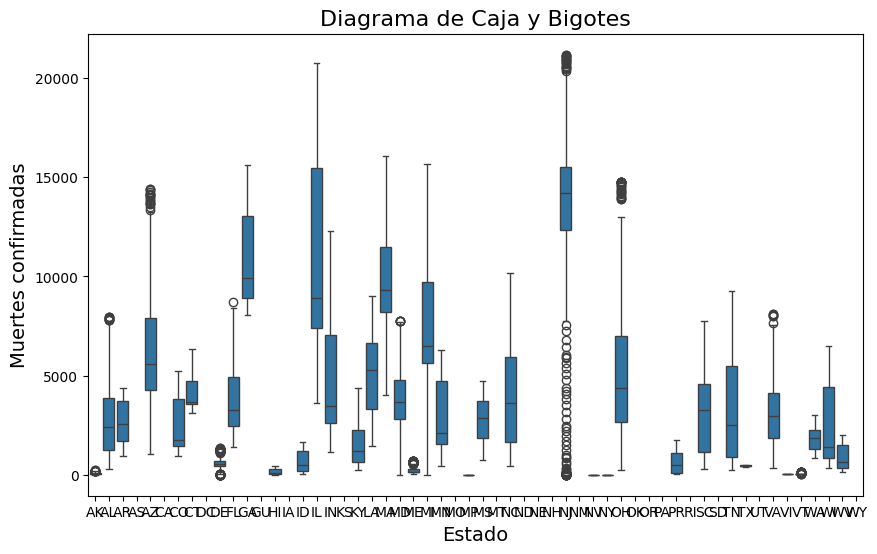

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='deathConfirmed', data=df_subset)

plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Muertes confirmadas', fontsize=14)

plt.show()

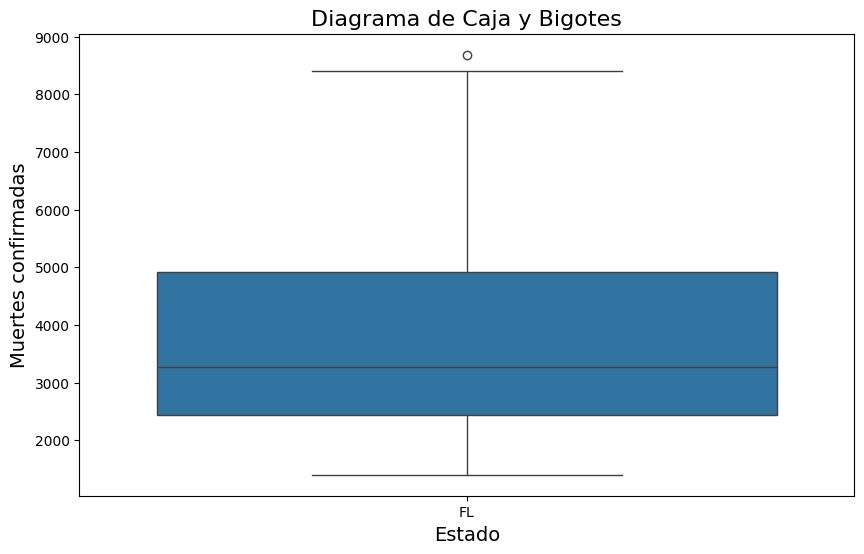

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

df_FL = df_subset[df_subset["state"] == 'FL']

plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(x='state', y='deathConfirmed', data=df_FL)


plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.xlabel('Estado', fontsize=14)
plt.ylabel('Muertes confirmadas', fontsize=14)

plt.show()

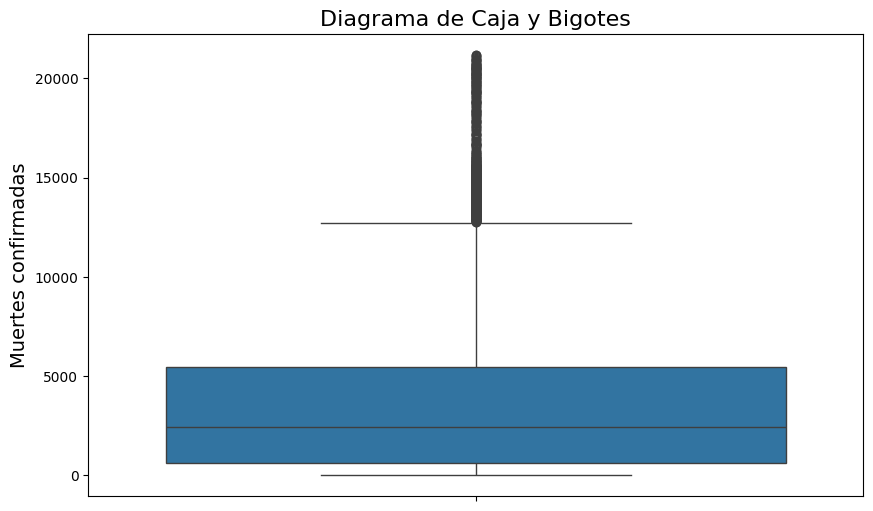

In [46]:
plt.figure(figsize=(10, 6))
box_plot = sns.boxplot(df_subset["deathConfirmed"])


plt.title('Diagrama de Caja y Bigotes', fontsize=16)
plt.ylabel('Muertes confirmadas', fontsize=14)

plt.show()